# Important Libraries

In [1]:
# Standard library imports
import os                          # To interact with the operating system
import shutil                      # For file operations (copy, move, etc.)
from io import BytesIO             # For byte operations

# Numerical and data manipulation libraries
import numpy as np                 # For numerical operations

# Data visualization libraries
import matplotlib.pyplot as plt     # For plotting graphs
import seaborn as sns             # For data visualization

# Image processing libraries
from PIL import Image, ImageOps, ImageFile     # For image processing
from tensorflow.keras.preprocessing.image import load_img, img_to_array  # For loading images

# Audio analysis library
import librosa                     # For audio analysis

# Machine learning libraries
from sklearn.model_selection import train_test_split  # For splitting data into train and test sets
from sklearn.preprocessing import LabelEncoder  # For encoding labels
from sklearn.preprocessing import StandardScaler  # For standardizing data
from sklearn.metrics import confusion_matrix, classification_report  # For evaluation metrics

# TensorFlow/Keras libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential  # For creating sequential models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  # For defining layers
from tensorflow.keras.utils import to_categorical  # For converting labels to categorical format
from tensorflow.keras.optimizers import Adam  # For optimization algorithms
from tensorflow.keras.applications import MobileNet  # For pre-trained MobileNet model
from tensorflow.keras.callbacks import EarlyStopping  # For early stopping during training


2024-07-06 09:40:59.290738: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-06 09:40:59.290863: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-06 09:40:59.427501: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Enable loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True  # This allows PIL to load images that might be partially corrupt or incomplete


In [3]:
# This cell loads the RGB images of Arabic alphabets from the specified dataset directory. 
# It preprocesses the images by resizing them to 224x224 pixels, normalizing their pixel values 
# to the range [0, 1], and storing them in a list. Corresponding labels for each image are 
# also stored and encoded into a one-hot format suitable for training a machine learning model.

# path to the dataset
data_path = 'RGB ArSL dataset'

data = []   # List to store image arrays
labels = []  # List to store corresponding labels for each image

# Get a list of categories (subdirectories) in the dataset
categories = os.listdir(data_path)

# Loop through each category (i.e., each subdirectory)
for category in categories:
    category_path = os.path.join(data_path, category)  # Construct the full path to the category directory
    
    # Loop over each image in the current category
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)  # Construct the full path to the image file
        
        # Load and resize the image to (224, 224) pixels
        img = load_img(img_path, target_size=(224, 224))
        
        # Convert the image to a NumPy array
        img_array = img_to_array(img)
        
        # Normalize pixel values to the range [0, 1]
        img_array /= 255.0
        
        # Append the processed image array to the data list
        data.append(img_array)
        
        # Append the corresponding category label to the labels list
        labels.append(category)

# Encode the labels into numerical format
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Convert the encoded labels to a categorical format (one-hot encoding)
categorical_labels = to_categorical(encoded_labels)


In [4]:
# This cell encodes the labels into a numerical format suitable for classification tasks, 
# converts them into a one-hot encoded format for multi-class classification, 
# and splits the dataset into training, validation, and test sets. 
# Finally, it converts the data and labels into NumPy arrays and prints their shapes 
# to confirm the dimensions of each dataset.

# Encode the labels into numerical format
label_encoder = LabelEncoder()
encoded_label = label_encoder.fit_transform(labels)

# Convert the encoded labels to a categorical format (one-hot encoding)
categorical_labels = to_categorical(encoded_label)

# Split the dataset into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(data, categorical_labels, test_size=0.2, random_state=42)

# Further split the test set into test and validation sets (50% each)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Convert lists to NumPy arrays for easier processing in model training
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Print the shapes of the datasets to confirm their dimensions
print(f'X_train shape is {X_train.shape}')
print(f'X_val shape is {X_val.shape}')
print(f'X_test shape is {X_test.shape}')
print(f'y_train shape is {y_train.shape}')
print(f'y_val shape is {y_val.shape}')
print(f'y_test shape is {y_test.shape}')


X_train shape is (6284, 224, 224, 3)
X_val shape is (786, 224, 224, 3)
X_test shape is (786, 224, 224, 3)
y_train shape is (6284, 31)
y_val shape is (786, 31)
y_test shape is (786, 31)


The model is built using transfer learning from a pre-trained MobileNet model, followed by additional dense layers.


In [ ]:
# This cell defines and compiles a MobileNet-based model for classifying RGB images of Arabic Sign Language.
# Early stopping is used to prevent overfitting during training.

# Define the input shape and number of classes
input_shape = (224, 224, 3)  # Image dimensions (height, width, channels)
num_classes = 31  # Number of output classes

# Load the MobileNet model with pre-trained ImageNet weights, excluding the top layer
base_model = MobileNet(weights='/kaggle/input/the-mobilenet-weights/tensorflow2/default/1/mobilenet_1_0_224_tf_no_top.h5', include_top=False, input_shape=input_shape)

# Build the model using a sequential architecture
model = Sequential([
    base_model,  # Add the base MobileNet model
    Flatten(),  # Flatten the output from the base model
    Dense(128, activation='relu'),  # Fully connected layer with ReLU activation
    Dense(64, activation='relu'),   # Fully connected layer with ReLU activation
    Dense(32, activation='relu'),   # Fully connected layer with ReLU activation
    Dense(num_classes, activation='softmax')  # Output layer with softmax activation for multi-class classification
])

# Compile the model with Adam optimizer and categorical crossentropy loss
optimizer = Adam(learning_rate=0.001)  # Set the learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [5]:
#trains a MobileNet-based model for classifying RGB images of Arabic Sign Language

history = model.fit(
    X_train,  # Training data
    y_train,  # Training labels
    batch_size=32,  # Number of samples per gradient update
    epochs=100,  # Number of epochs to train the model
    validation_data=(X_val, y_val),  # Validation data to monitor overfitting
    callbacks=[early_stopping],  # Callback for early stopping
    verbose=1  # Print training progress
)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')  # Print test accuracy as a percentage


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ ?                      │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

None
Epoch 1/100
  2/197 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.0625 - loss: 4.0192   

I0000 00:00:1720259397.162478     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


197/197 ━━━━━━━━━━━━━━━━━━━━ 66s 183ms/step - accuracy: 0.0891 - loss: 3.6246 - val_accuracy: 0.2379 - val_loss: 2.4093
Epoch 2/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.4191 - loss: 1.7551 - val_accuracy: 0.3893 - val_loss: 2.6228
Epoch 3/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.6884 - loss: 0.9359 - val_accuracy: 0.7316 - val_loss: 1.0164
Epoch 4/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.7979 - loss: 0.6347 - val_accuracy: 0.8257 - val_loss: 0.5454
Epoch 5/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.8905 - loss: 0.3739 - val_accuracy: 0.8626 - val_loss: 0.5561
Epoch 6/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9257 - loss: 0.2637 - val_accuracy: 0.8830 - val_loss: 0.5107
Epoch 7/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9416 - loss: 0.2066 - val_accuracy: 0.8486 - val_loss: 0.5948
Epoch 8/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9389 - loss: 0.2424 - val

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step


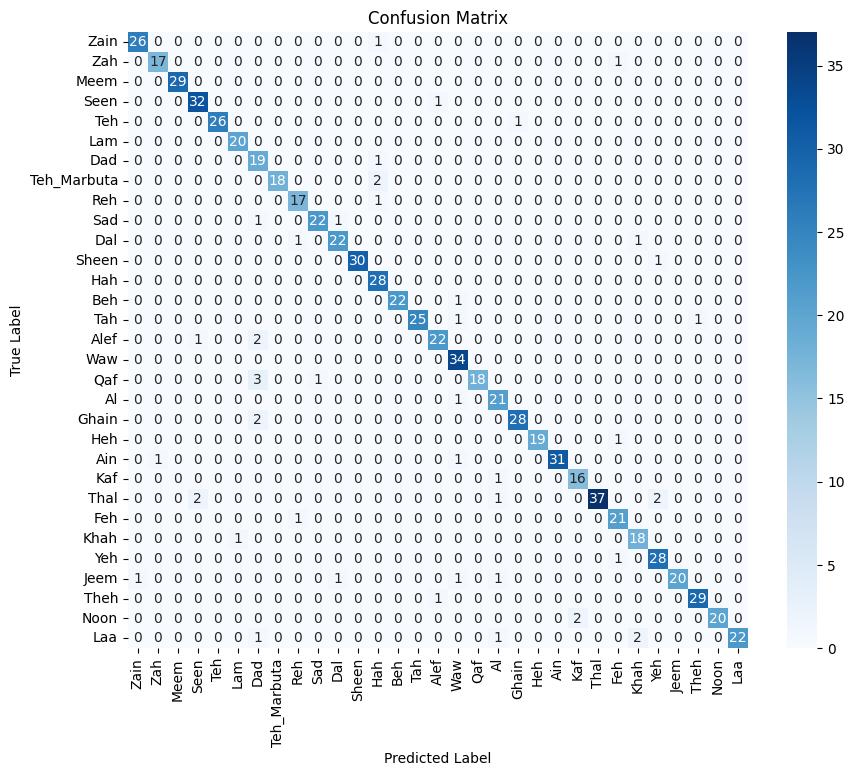


Classification Report:
              precision    recall  f1-score   support

        Zain       0.96      0.96      0.96        27
         Zah       0.94      0.94      0.94        18
        Meem       1.00      1.00      1.00        29
        Seen       0.91      0.97      0.94        33
         Teh       1.00      0.96      0.98        27
         Lam       0.95      1.00      0.98        20
         Dad       0.68      0.95      0.79        20
 Teh_Marbuta       1.00      0.90      0.95        20
         Reh       0.89      0.94      0.92        18
         Sad       0.96      0.92      0.94        24
         Dal       0.92      0.92      0.92        24
       Sheen       1.00      0.97      0.98        31
         Hah       0.85      1.00      0.92        28
         Beh       1.00      0.96      0.98        23
         Tah       1.00      0.93      0.96        27
        Alef       0.92      0.88      0.90        25
         Waw       0.87      1.00      0.93        34
   

In [6]:
# Make predictions on the test dataset
y_pred = model.predict(X_test)  # Get predicted probabilities for each class
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true_classes = np.argmax(y_test, axis=1)  # Get true class labels

# Generate confusion matrix to visualize the performance of the model
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')  # Title of the plot
plt.xlabel('Predicted Label')  # X-axis label
plt.ylabel('True Label')  # Y-axis label
plt.show()

# Print the classification report to evaluate the model's performance
print('\nClassification Report:')
print(classification_report(y_true_classes, y_pred_classes, target_names=categories))

Results Explanation:
The confusion matrix shows how many instances of each class were predicted correctly (diagonal elements) 

and how many were misclassified (off-diagonal elements). A higher value on the diagonal indicates better performance.

For example, if 'Meem' has a count of 29 on the diagonal and 0 elsewhere, it means all instances were correctly classified.

The classification report provides detailed metrics:
- Precision: The ratio of true positive predictions to the total predicted positives (True Positives + False Positives).
- Recall: The ratio of true positive predictions to the actual positives (True Positives + False Negatives).
- F1-Score: The harmonic mean of precision and recall, providing a balance between the two.
- Support: The number of actual occurrences of each class in the specified dataset.

Example Interpretations from the Report:
1. For the class 'Meem':
- Precision: 1.00 indicates that all predicted instances of 'Meem' were correct.
- Recall: 1.00 means that the model identified all actual 'Meem' instances.
- F1-Score: 1.00 reflects a perfect balance between precision and recall.

2. For the class 'Dad':
- Precision: 0.68 shows that some predicted instances of 'Dad' were incorrect, indicating room for improvement.
- Recall: 0.95 means that most actual 'Dad' instances were identified, but some were missed (False Negatives).
- F1-Score: 0.79 indicates an imbalance between precision and recall, suggesting further tuning may be necessary.

Overall Model Performance:

The accuracy of 0.94 means that the model correctly classified 94% of the test samples.

The macro and weighted averages provide an overall assessment across all classes, which is also 0.94, indicating good performance.

This detailed analysis helps identify strengths and weaknesses in the model's performance,
guiding future improvements such as further tuning, additional training data, or addressing specific class misclassifications.


In [9]:
def predict_image(image_path, model, label_encoder):
    # Load and preprocess the image for prediction
    img = load_img(image_path, target_size=(224, 224))  # Load the image and resize to 224x224 pixels
    img_array = img_to_array(img)  # Convert the image to a numpy array
    img_array = img_array / 255.0  # Normalize pixel values to be between 0 and 1
    img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension, as the model expects input in batches

    # Make a prediction using the trained model
    predictions = model.predict(img_array)  # Get the model's predictions for the input image
    predicted_class_index = np.argmax(predictions)  # Get the index of the class with the highest predicted probability

    # Decode the prediction to the corresponding label using the label encoder
    predicted_label = label_encoder.inverse_transform([predicted_class_index])[0]  # Convert index back to label
    
    return predicted_label  # Return the predicted label

# Path to the image you want to test
test_image_path = 'RGB ArSL dataset/Ain/Ain_0.jpg'

# Predict the label using the trained model
predicted_label = predict_image(test_image_path, model, label_encoder)

# Output the predicted label
print(f"The predicted label for the image is: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
The predicted label for the image is: Ain
